# DTSA 5509 Supervised Learning Final Project
## Using Supervised Learning Classifiers to Predict Student Success in School

## 0 - Project Topic

The topic of this work intends to model student achievement in secondary education using classification techniques, to evaluate if a good predictive accuracy could be achieved, based on student grades, demographic, social related features, with the aim of identifying the key variables that affect students' educational success/failure.

For achieving the objectives of this project, the study follows the overall process of knowledge discovery from data, consisting of:

1. Developing an understanding of the target dataset,
2. Removing noise and deciding on strategies for handling missing data fields,
3. Finding useful features to represent the data depending on the goal of the analysis,
4. Selecting the methods to be used for data sampling, and prediction,
5. Interpreting and evaluating the performance of the prediction models,
6. Concluding on the discovered knowledge.

For the modeling tasks, different techniques for data standardization (i.e. StandardScaler, Normalizer), oversampling (i.e. Random Oversampler, SMOTE), feature selection (i.e. Mutual Information, chi2, PCA), and classification (i.e. Decision Trees, Random Forest, AdaBoost, and Support Vector Machines) will be evaluated under a binary target variable consisting of the student's course success/failure. 

As a result of this study, school resources could be better managed by targeting the most vulnerable students based on their demographic and social characteristics.

In [1]:
##### added line to ensure plots are showing
%matplotlib inline
#####

# Installations
# pip install ucimlrepo
# pip install -U imbalanced-learn

# Libraries
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sea 

## 1 - The Dataset

The dataset is *Student Performance*, donated by *Pablo Cortez* (2014), and published in *UC Irvine Machine Learning Repository*. The dataset includes the student grades, demographic, social and school related features for Portuguese language courses in two Portuguese schools. The data was collected by using school reports and questionnaires. 

**Data size:** 154 KB  
**Intances:** 649  
**Features:** 30  
**Has Missing Values:** No  
**Link to dataset page:** https://archive.ics.uci.edu/dataset/320/student+performance  

In [2]:
# fetch dataset 
student_performance = fetch_ucirepo(id=320) 
  
# data as pandas dataframes 
X = student_performance.data.features 
y = student_performance.data.targets 

In [3]:
# Variables information 
print(student_performance.variables) 

          name     role         type      demographic  \
0       school  Feature  Categorical             None   
1          sex  Feature       Binary              Sex   
2          age  Feature      Integer              Age   
3      address  Feature  Categorical             None   
4      famsize  Feature  Categorical            Other   
5      Pstatus  Feature  Categorical            Other   
6         Medu  Feature      Integer  Education Level   
7         Fedu  Feature      Integer  Education Level   
8         Mjob  Feature  Categorical       Occupation   
9         Fjob  Feature  Categorical       Occupation   
10      reason  Feature  Categorical             None   
11    guardian  Feature  Categorical             None   
12  traveltime  Feature      Integer             None   
13   studytime  Feature      Integer             None   
14    failures  Feature      Integer             None   
15   schoolsup  Feature       Binary             None   
16      famsup  Feature       B

In [4]:
# metadata 
#print(student_performance.metadata) 

## 2 - Data Cleaning

Let's address duplicated and missing values, outliers, unnecessary features, variables without predicting power, and categorical data.

### 2.2 Missing values

The *Dataset Information* page indicates that there are no missing values. However, let's do a quick check to verify the statement:

In [5]:
X.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
dtype: int64

In [6]:
y.isna().sum()

G1    0
G2    0
G3    0
dtype: int64

No missing values either in the feature variables or in the target variables were found.

### 2.1 Duplicated values

Let's check on duplicated values:

In [7]:
X.duplicated().value_counts()

False    649
dtype: int64

No duplicated values found in the dataset.

### 2.3 Outliers

Let's check on outliers by looking at the correlation among the first, second, and final grades, with the aim of identifying outliers, that may affect the performance of the model.

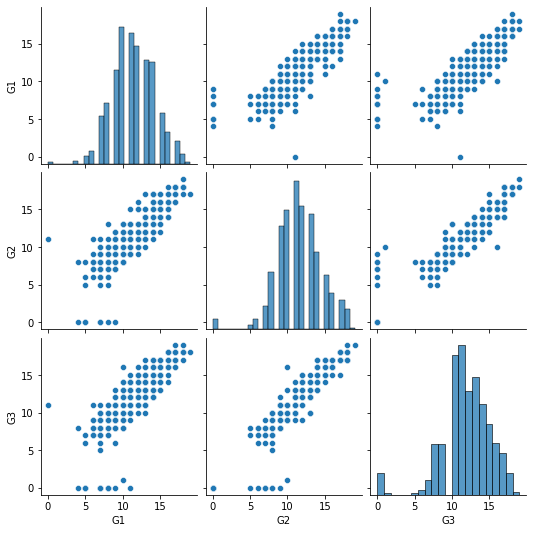

In [8]:
sea.pairplot(y)
plt.show()

Looking at the pairplot we can observed some outliers in the student grades, which must be removed.

For detecting the outliers, we will use EllipticEnvelope from sklearn, by setting the proportion of outliers to be eliminated from the dataset:

In [9]:
from sklearn.covariance import EllipticEnvelope
X_cln = X.copy()
y_cln = y.copy()
ee = EllipticEnvelope(contamination = 0.03)
outliers_ee = ee.fit_predict(y)
X_cln['outlier_ee'] = pd.DataFrame(outliers_ee)
y_cln['outlier_ee'] = pd.DataFrame(outliers_ee)

print(X_cln['outlier_ee'].value_counts())

 1    629
-1     20
Name: outlier_ee, dtype: int64


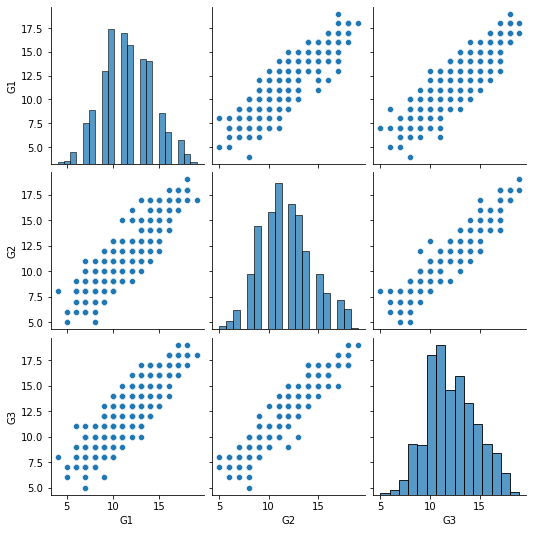

In [10]:
y_cln = y_cln[y_cln['outlier_ee']==1]
y_cln = y_cln.drop(['outlier_ee'], axis=1)
X_cln = X_cln[X_cln['outlier_ee']==1]
X_cln = X_cln.drop(['outlier_ee'], axis=1)
sea.pairplot(y_cln)
plt.show()

The contamination was set at 3%, removing the most evident outliers observed in previous pairplot.

### 2.4 Feature selection

Let's drop unnecessary variables.

#### 2.4.1 Target Variables

Our aim is to predict the student's course success/failure, therefore, the focus will be based on the course *final grade (G3)*, discarding *first period grade (G1)* and *second period grade (G2)*: 

In [11]:
y_cln = y_cln.drop(['G1', 'G2'], axis=1)

#### 2.4.2 Feature Variables

The focus will be generating a model based on student's demographic and social features, not on the school related features. Therefore, the school features will be discarded: 

In [12]:
X_cln = X_cln.drop(['school', 'reason'], axis=1)

### 2.5 Transform variables

Next, let's look at the types of data:

In [13]:
X_cln.dtypes

sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
dtype: object

In [14]:
y_cln.dtypes

G3    int64
dtype: object

Looking at the attributes of the data, most of the prediction variables are categorical, except for *age*, *failures*, and *absences*. For the categorical variables, some are ordinal, and some are nominal. For the nominal variables, we will encode the variables (which involves transforming the column into multiple binary columns), as most classification algorithms are primarily designed to operate with numerical data only.

Let's encode the nominal variables:

In [15]:
# Transform all object type variables
list_str_obj_cols = X_cln.columns[X_cln.dtypes == "object"].tolist()
X_trf = pd.get_dummies(X_cln, prefix=list_str_obj_cols, columns=list_str_obj_cols
                    , drop_first=True)

In [16]:
# Display results    
X_trf.dtypes

age                int64
Medu               int64
Fedu               int64
traveltime         int64
studytime          int64
failures           int64
famrel             int64
freetime           int64
goout              int64
Dalc               int64
Walc               int64
health             int64
absences           int64
sex_M              uint8
address_U          uint8
famsize_LE3        uint8
Pstatus_T          uint8
Mjob_health        uint8
Mjob_other         uint8
Mjob_services      uint8
Mjob_teacher       uint8
Fjob_health        uint8
Fjob_other         uint8
Fjob_services      uint8
Fjob_teacher       uint8
guardian_mother    uint8
guardian_other     uint8
schoolsup_yes      uint8
famsup_yes         uint8
paid_yes           uint8
activities_yes     uint8
nursery_yes        uint8
higher_yes         uint8
internet_yes       uint8
romantic_yes       uint8
dtype: object

In [17]:
X_trf.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
1,17,1,1,1,2,0,5,3,3,1,...,0,0,0,1,0,0,0,1,1,0
2,15,1,1,1,2,0,4,3,2,2,...,1,0,1,0,0,0,1,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,1,0,0,1,0,1,1,1,1,1
4,16,3,3,1,2,0,4,3,2,1,...,0,0,0,1,0,0,1,1,0,0
5,16,4,3,1,2,0,5,4,2,1,...,1,0,0,1,0,1,1,1,1,0


In the case of the target variable (*final score G3*), it will be converted into a pass/fail (binary) class, pass if G3≥10, else fail:

In [18]:
y_trf = y_cln.copy()
# fail
y_trf[y_trf['G3']<10] = 0
# pass
y_trf[y_trf['G3']>=10] = 1

y_trf.value_counts()

G3
1     546
0      83
dtype: int64

## 3 - Exploratory Data Analysis

### 3.1 Data's Distribution

Let's get an idea of the distribution of the variables by plotting a histogram of each feature variable:

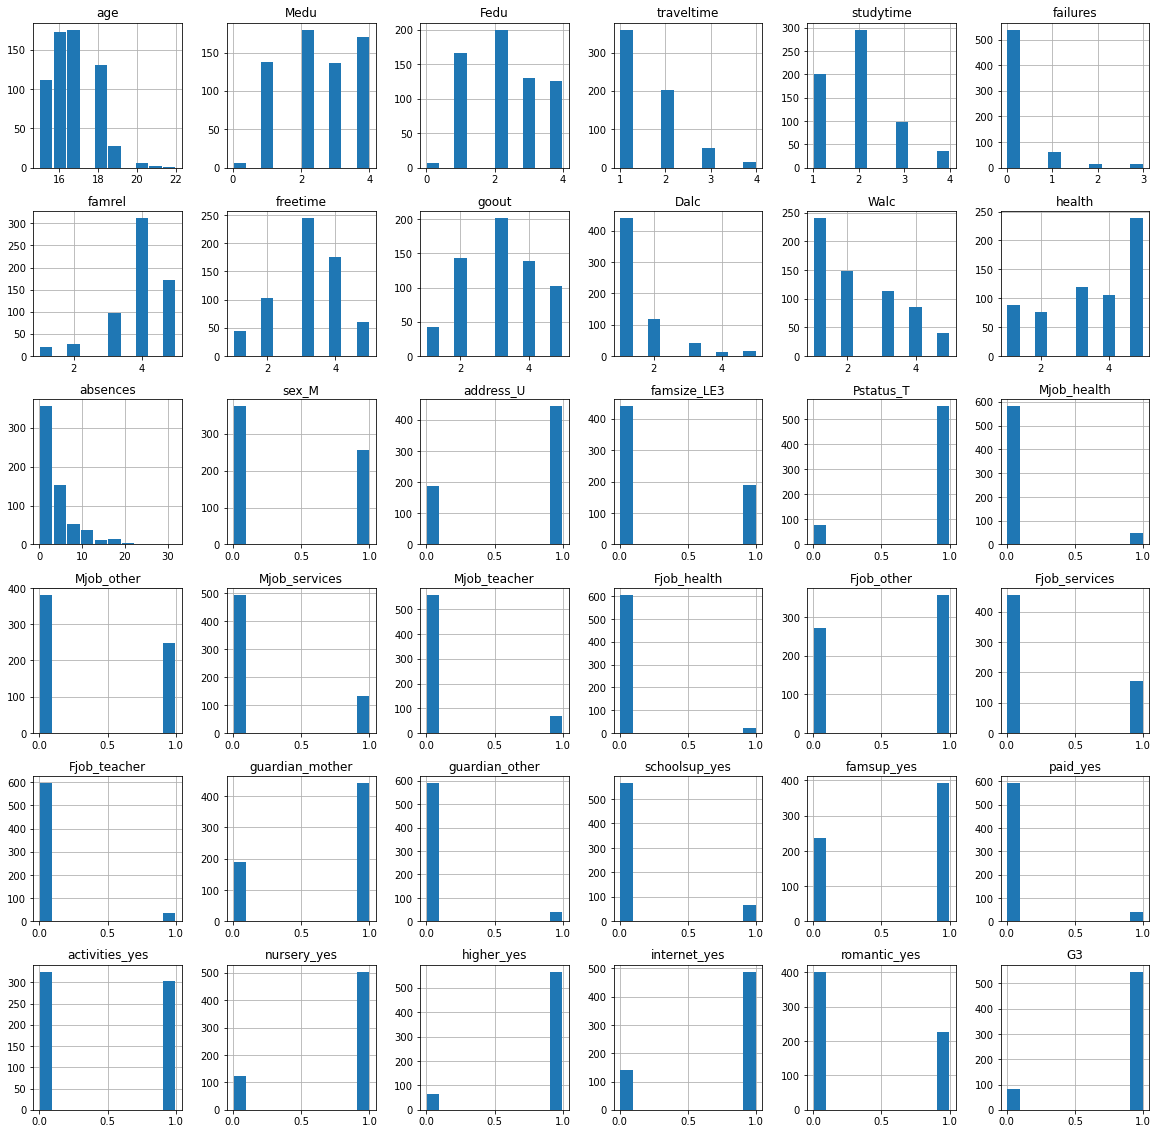

In [19]:
df = X_trf.copy()
df['G3'] = y_trf['G3']
df.hist(figsize=(20,20), zorder=2, rwidth=0.9)
plt.show()

From the histograms, we can observe some skewness, and outliers on some of the feature variables such as *age*. However, the most concerning finding is the class imbalance in the target variable *G3*, that must be mitigated using oversampling techniques.

### 3.2 Imbalance Classes

Prediction performance will be affected by the imbalanced of the target variable *G3*, corresponding to the difference of the number of samples in the two classes (pass/fail). 

Let's visualize the effect of two oversampling techniques on handling the class imbalance in the target variable *G3*:

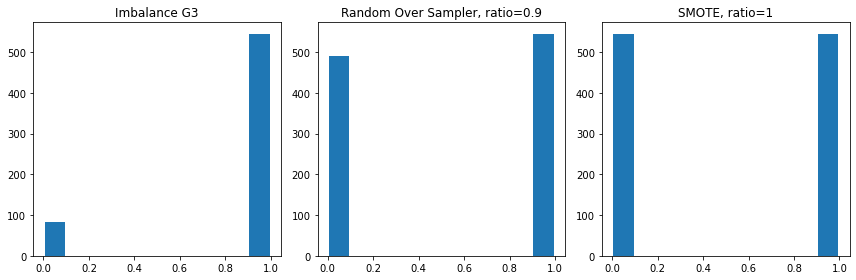

In [20]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# RandomOverSampler
ros = RandomOverSampler(sampling_strategy=0.9, random_state=42)
X_ros, y_ros = ros.fit_resample(X_trf, y_trf)

# SMOTE
smt = SMOTE(sampling_strategy=1, random_state=42)
X_smt, y_smt = smt.fit_resample(X_trf, y_trf)

#define subplots
fig, ax = plt.subplots(1,3,figsize=(12,4))

# Imbalance class
plt.subplot(1,3,1)
plt.hist(y_trf,rwidth=0.90)
plt.title('Imbalance G3')

# RandomOverSampler
plt.subplot(1,3,2)
plt.hist(y_ros,rwidth=0.90)
plt.title('Random Over Sampler, ratio=0.9')

# SMOTE
plt.subplot(1,3,3)
plt.hist(y_smt,rwidth=0.90)
plt.title('SMOTE, ratio=1')

fig.tight_layout(h_pad=20)

#display subplots 
plt.show()

- *RandomOver Sample* over-samples the minority class by picking samples at random with replacement.
- *SMOTE* over-samples the minority class by synthesizing new synthetic data close to the other points belonging to the minority class.

### 3.3 Correlation Analysis

Let's visualize which features seem to be correlated, and which are related to the target variable *G3*, by plotting a correlation matrix: 

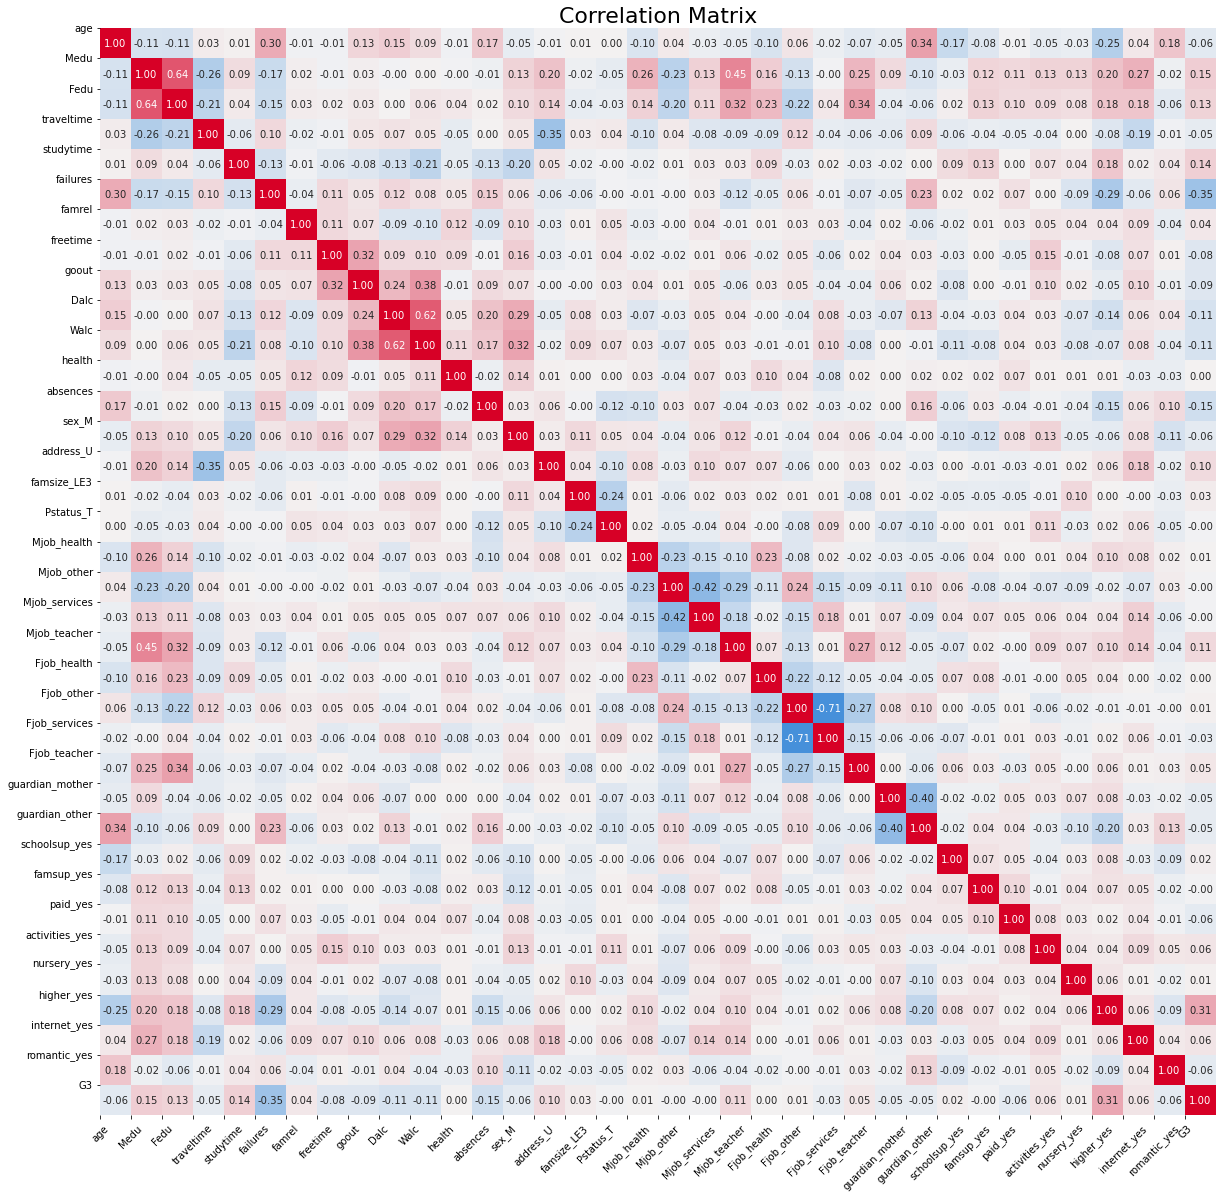

In [21]:
correlation = df.corr()

fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
rdgn = sea.diverging_palette(h_neg=255, h_pos=10, s=100, l=45, n=256, sep=1, as_cmap=True)
sea.heatmap(data=correlation, cmap =rdgn, center = 0, fmt=".2f", annot=True, annot_kws={'fontname': 'sans-serif', 'size': 10}, cbar=False)

ticks = np.arange(0,len(df.columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
ax.set_title( "Correlation Matrix" , size = 22 )
plt.show()

By looking at the correlation matrix, we can observe that most of feature variables are not strongly correlated to the target variable *G3*, being the top 5 most correlated features:
1. failures
2. higher_yes
3. Medu
4. absences
5. studytime

Moreover, some features strongly correlated among themselves, such as: between *Medu* and *Fedu*, between *Dalc* and *Walc*, and between *Fjob_services* and *Fjob_other*.

### 3.4 Feature Importance

Let's normalize the data before performing the feature importance analysis for preventing features with larger scales dominating the process.

In [22]:
### Normalization
from sklearn.preprocessing import normalize

X_nrm = normalize(X_trf)

Let's research on features importance using *SelectKBest* from *sklearn:*

In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

In [24]:
print("Top 5 features by Chi-squared:")
selected_features = SelectKBest(chi2, k=5).fit(X_nrm, y_trf.values.ravel())
for feature_name, selected in zip(X_trf.columns, selected_features.get_support()):
    if selected:
        print("-", feature_name)

Top 5 features by Chi-squared:
- Medu
- Fedu
- failures
- absences
- Mjob_teacher


In [25]:
print("Top 5 features by Mutual information for Classification:")
selected_features = SelectKBest(mutual_info_classif, k=5).fit(X_nrm, y_trf.values.ravel())
for feature_name, selected in zip(X_trf.columns, selected_features.get_support()):
    if selected:
        print("-", feature_name)

Top 5 features by Mutual information for Classification:
- Medu
- failures
- address_U
- schoolsup_yes
- higher_yes


Next, let's check what variables are important using PCA, by plotting a Scree plot:

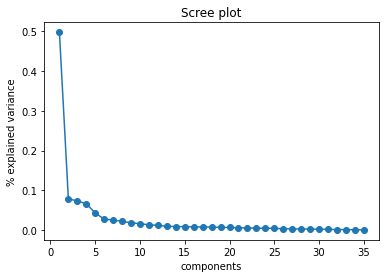

In [26]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_nrm)

plt.plot(range(1,len(pca.components_)+1),pca.explained_variance_ratio_,'-o')
plt.xlabel('components')
plt.ylabel('% explained variance')
plt.title("Scree plot")
plt.show()

Let's identify the important features at a threshold of 20% explained variance for the top 5 components:

In [27]:
interesting_variables = set()
threshold = 0.2
variables = []
weights = []

for index in range(0,6):

    for weight, variable in zip(pca.components_[index], X_trf.columns):

        if np.abs(weight) > threshold:
            variables.append(variable)
            weights.append(weight)
            #print(index)
            #print(variable)
            #print(weight)

interesting_variables = set(variables)

print("Top features by PCA:")
print(interesting_variables)

Top features by PCA:
{'Walc', 'goout', 'age', 'famrel', 'freetime', 'Medu', 'Dalc', 'health', 'absences', 'Fedu'}


All in all, we can observe from the different methods that the most important features are:
- Medu
- Fedu
- absences
- failures
- higher_yes

Feasure selection techniques will be applied during the modelling tasks.

## 4 - Models

Let's prepare the modeling setup by making a function that applies different techniques on:
1. Standardization
2. Oversampling
3. Feature Selection
4. Cross Validation
5. Classification  

Then, returns the performing model, three evaluation metrics: accuracy, precision and auroc, resulting from the mean over the number of CV folds, and the mean of the three metrics (mean score).

### 4.1 Model Selection Process

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import AdaBoostClassifier as AB
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
import warnings

def selection_process(X_train, y_train, stdr, osr, st, fs, cv, nf, clsfr):
    
    np.random.seed(42)
    
    ppln_steps = []
    
    # Standardizer
    if stdr == 'SS':
        ppln_steps.append(('scaler', StandardScaler()))
    
    elif stdr == 'NM':
        ppln_steps.append(('normalizer', Normalizer()))
    
    # Oversampler
    if osr == 'ROS':
        ppln_steps.append(('ROS', RandomOverSampler(sampling_strategy='auto', random_state=42)))
    
    elif osr == 'SM':
        ppln_steps.append(('SMOTE', SMOTE(sampling_strategy='auto', random_state=42)))        
    
    # Features Selection
    if st == 'PCA':
        ppln_steps.append(('PCA', PCA(n_components=fs)))

    elif st == 'chi2':
        ppln_steps.append(('chi2', SelectKBest(chi2, k=fs)))
        
    elif st == 'MI':
        ppln_steps.append(('mutual_information', SelectKBest(mutual_info_classif, k=fs)))
    
    # Cross-validator
    if cv == 'SKF':
        cv = StratifiedKFold(n_splits=nf, shuffle=True, random_state=42)

    elif cv == 'SS':
        cv = ShuffleSplit(n_splits=nf, test_size=.25, random_state=42)
    
    else:
        cv = nf
    
    # Metrics
    metrics = ['accuracy', 'precision', 'roc_auc']   
        
    # Model
    if clsfr == 'DT':
        ppln_steps.append(('DT', DT()))

    elif clsfr == 'RF':
        ppln_steps.append(('RF', RF()))
        
    elif clsfr == 'AB':
        ppln_steps.append(('AB', AB()))    
    
    elif clsfr == 'SVC':
        ppln_steps.append(('SVC', SVC())) 
    
    # Pipeline
    #print(ppln_steps)
    pipe = Pipeline(steps=ppln_steps)
    
    # Cross Validation
    outcomes = cross_validate(pipe, X_train, y_train, scoring=metrics, cv=cv, return_train_score=False)
    
    accuracy = np.mean(outcomes['test_accuracy'])
    precision = np.mean(outcomes['test_precision'])
    auroc = np.mean(outcomes['test_roc_auc'])
        
    ###
    
    return accuracy, precision, auroc, ppln_steps

Let's evaluate different pre-processing techniques and classification algorithms (using their default hyperparameter values) to find the best setups: 

In [29]:
warnings.filterwarnings("ignore")

# Split dataset into a train subset and a test subset
X_train, X_test, y_train, y_test = train_test_split(X_trf, y_trf, test_size = 0.3, random_state=42)

# Techniques:
stdrs = ['SS', 'NM']
osrs = ['None', 'ROS', 'SM']
sts = ['None', 'PCA', 'chi2', 'MI']
fss = [5, 10, 15]
cvs = ['CV', 'SKF', 'SS']
nfs = [5]
clsfrs = ['DT', 'RF', 'AB', 'SVC']

# iteration values list
i_stdr = []
i_osr = []
i_st = []
i_fs = []
i_cv = []
i_nf = []
i_clsfr = []
i_acc = []
i_prc = []
i_roc = []
i_score = []
i_steps = []

# Evaluate different models setups:
# stdr, osr, st, fs, cv, nf, clsfr

for clsfr in clsfrs:
    for cv in cvs:
        for nf in nfs:  
            for stdr in stdrs:
                for osr in osrs:
                    for st in sts:
                        if st=='None':
                            
                            fs='None'
                            acc, prc, roc, stp = selection_process(X_train, y_train, stdr, osr, st, fs, cv, nf, clsfr)
                            avg_score = np.mean([acc, prc, roc])

                            # store input/result values
                            i_stdr.append(stdr)
                            i_osr.append(osr)
                            i_st.append(st)
                            i_fs.append(fs)
                            i_cv.append(cv)
                            i_nf.append(nf)
                            i_clsfr.append(clsfr)
                            i_acc.append(acc)
                            i_prc.append(prc)
                            i_roc.append(roc)
                            i_score.append(avg_score)
                            i_steps.append(stp)                        
                        
                        elif (st=='chi2' and stdr=='SS'):
                            # chi2 doesn't process negative values generated from StandardScaler
                            continue
                        
                        else:
                            for fs in fss:                        
                                #print(stdr, osr, st, fs, cv, nf, clsfr)
                                acc, prc, roc, stp = selection_process(X_train, y_train, stdr, osr, st, fs, cv, nf, clsfr)
                                avg_score = np.mean([acc, prc, roc])

                                # store input/result values
                                i_stdr.append(stdr)
                                i_osr.append(osr)
                                i_st.append(st)
                                i_fs.append(fs)
                                i_cv.append(cv)
                                i_nf.append(nf)
                                i_clsfr.append(clsfr)
                                i_acc.append(acc)
                                i_prc.append(prc)
                                i_roc.append(roc)
                                i_score.append(avg_score)
                                i_steps.append(stp)

dict_eval = {'CLSFR': i_clsfr, 'CV': i_cv, 'NF': i_nf, 'STDR': i_stdr, 'OSR':i_osr, 'ST': i_st, 'FS': i_fs, 
              'acc': i_acc, 'prc': i_prc, 'roc': i_roc, 'avg_score': i_score, 'steps': i_steps} 

df_eval = pd.DataFrame(dict_eval)

Let's get a glimpse of the results of the model selection process:

In [30]:
df_eval

,CLSFR,CV,NF,STDR,OSR,ST,FS,acc,prc,roc,avg_score,steps
0,DT,CV,5,SS,None,None,None,0.795455,0.875830,0.581128,0.750804,"[(scaler, StandardScaler()), (DT, DecisionTree..."
1,DT,CV,5,SS,None,PCA,5,0.779545,0.861445,0.533641,0.724877,"[(scaler, StandardScaler()), (PCA, PCA(n_compo..."
2,DT,CV,5,SS,None,PCA,10,0.768182,0.872184,0.565128,0.735165,"[(scaler, StandardScaler()), (PCA, PCA(n_compo..."
3,DT,CV,5,SS,None,PCA,15,0.786364,0.872662,0.569436,0.742820,"[(scaler, StandardScaler()), (PCA, PCA(n_compo..."
4,DT,CV,5,SS,None,MI,5,0.854545,0.896116,0.667590,0.806084,"[(scaler, StandardScaler()), (mutual_informati..."
...,...,...,...,...,...,...,...,...,...,...,...,...
607,SVC,SS,5,NM,SM,chi2,10,0.763636,0.921208,0.773967,0.819604,"[(normalizer, Normalizer()), (SMOTE, SMOTE(ran..."
608,SVC,SS,5,NM,SM,chi2,15,0.760000,0.930210,0.774177,0.821463,"[(normalizer, Normalizer()), (SMOTE, SMOTE(ran..."
609,SVC,SS,5,NM,SM,MI,5,0.758182,0.896429,0.713748,0.789453,"[(normalizer, Normalizer()), (SMOTE, SMOTE(ran..."
610,SVC,SS,5,NM,SM,MI,10,0.732727,0.897130,0.688918,0.772925,"[(normalizer, Normalizer()), (SMOTE, SMOTE(ran..."


Let's display the best setup based on cross-validation performance:

In [31]:
# The best setup:
best_setup = df_eval[df_eval['avg_score']==df_eval['avg_score'].max()]
best_setup

,CLSFR,CV,NF,STDR,OSR,ST,FS,acc,prc,roc,avg_score,steps
180,RF,CV,5,NM,None,chi2,15,0.863636,0.876154,0.84359,0.861127,"[(normalizer, Normalizer()), (chi2, SelectKBes..."


Next, let's look at the top setups within an average score above 85%:

In [32]:
# Top setups:
df_eval[df_eval['avg_score']>.85]

,CLSFR,CV,NF,STDR,OSR,ST,FS,acc,prc,roc,avg_score,steps
162,RF,CV,5,SS,ROS,PCA,10,0.868182,0.889794,0.795897,0.851291,"[(scaler, StandardScaler()), (ROS, RandomOverS..."
179,RF,CV,5,NM,None,chi2,10,0.865909,0.883761,0.817641,0.855771,"[(normalizer, Normalizer()), (chi2, SelectKBes..."
180,RF,CV,5,NM,None,chi2,15,0.863636,0.876154,0.843590,0.861127,"[(normalizer, Normalizer()), (chi2, SelectKBes..."
189,RF,CV,5,NM,ROS,chi2,10,0.863636,0.892933,0.811282,0.855950,"[(normalizer, Normalizer()), (ROS, RandomOverS..."
218,RF,SKF,5,SS,SM,None,None,0.865909,0.883404,0.801538,0.850284,"[(scaler, StandardScaler()), (SMOTE, SMOTE(ran..."
230,RF,SKF,5,NM,None,chi2,10,0.856818,0.882268,0.820923,0.853337,"[(normalizer, Normalizer()), (chi2, SelectKBes..."
231,RF,SKF,5,NM,None,chi2,15,0.852273,0.876405,0.823590,0.850756,"[(normalizer, Normalizer()), (chi2, SelectKBes..."
234,RF,SKF,5,NM,None,MI,15,0.859091,0.875454,0.822462,0.852336,"[(normalizer, Normalizer()), (mutual_informati..."
251,RF,SKF,5,NM,SM,chi2,15,0.840909,0.902963,0.807385,0.850419,"[(normalizer, Normalizer()), (SMOTE, SMOTE(ran..."
254,RF,SKF,5,NM,SM,MI,15,0.843182,0.905252,0.814769,0.854401,"[(normalizer, Normalizer()), (SMOTE, SMOTE(ran..."


We can observe that the best classifier in the *Random Forest Classifier*

### 4.2 Evaluation Process

Next, let's set a function that applies and evaluates a model setup found during cross-validation against the test sets:

In [33]:
warnings.filterwarnings("ignore")

def model_evaluation(X_train, y_train, X_test, y_test, ppln_steps):
        
    # Pipeline
    pipe = Pipeline(steps=ppln_steps)
    
    predictor = pipe.fit(X_train, y_train.values.ravel())
    
    y_pred = predictor.predict(X_test)
    
    ### Score Metrics
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import confusion_matrix
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_pred)
    avg_score = np.mean([accuracy, precision, auroc])
    conf_mtrx = confusion_matrix(y_test, y_pred)
    
    return accuracy, precision, auroc, avg_score, conf_mtrx, predictor

Now, let's evaluate the performance of the best model setup against the test set:

In [34]:
ps = list(best_setup['steps'])[0]
print('setup:')
print(best_setup[best_setup.columns[:-1]])
print()
acc, prc, roc, avg_scr, cm, mdl = model_evaluation(X_train, y_train, X_test, y_test, ps)
print('test accuracy:', acc)
print('test precision:', prc)
print('test au_roc:', roc)
print('test avg_score:', avg_scr)
print('test confusion matrix:', cm)

setup:
    CLSFR  CV  NF STDR   OSR    ST  FS       acc       prc      roc  avg_score
180    RF  CV   5   NM  None  chi2  15  0.863636  0.876154  0.84359   0.861127

test accuracy: 0.8835978835978836
test precision: 0.9162011173184358
test au_roc: 0.5628654970760233
test avg_score: 0.7875548326641142
test confusion matrix: [[  3  15]
 [  7 164]]


From above results, we can observe an increase in *accuracy* and *precision* in detrimental of the model capacity of distinguishing (*au_roc*) between *pass* and *fail* classes. This could be caused by lack of imbalance mitigation in the model, as OSR value is 'None'. 

### 4.3 Features Importance 

As the best classifier is a Random Forest algorithm, let's list the top 10 features based on their importance (average reduction in Gini impurity across all trees) on the test set:

In [35]:
# Top 10 most important features:
ftrs = []
f_imprt = []
for c, column in enumerate(X_test.columns[:len(mdl[-1].feature_importances_)]):
    #print(c, column)
    if mdl[-1].feature_importances_[c] in sorted(mdl[-1].feature_importances_)[-15:]:
        ftrs.append(column)
        f_imprt.append(mdl[-1].feature_importances_[c])
df_fi = pd.DataFrame([f_imprt], columns = ftrs) 
df_fi.index = ['MDI']
df_fi.sort_values(by=['MDI'], axis=1, ascending=False)

,studytime,sex_M,traveltime,freetime,failures,age,famrel,Fedu,Medu,address_U,Dalc,goout,Walc,health,absences
MDI,0.129212,0.119655,0.086745,0.085899,0.085081,0.079251,0.077657,0.077444,0.075308,0.058131,0.058059,0.052992,0.008455,0.003801,0.002309


### 4.4 Hyperparameters Tuning

Even though our model selection process used the classification algorithms default hyperparameters values, let's develop a process to perform hyperparameter tuning for the selected classification algorithm:

In [36]:
def model_hyperparameter_eval(X_train, y_train, X_test, y_test, ppln_steps, cv, nf, prmtrs, scoring):
    from sklearn.model_selection import GridSearchCV

    # Cross-validator
    if cv == 'SKF':
        cv = StratifiedKFold(n_splits=nf, shuffle=True, random_state=42)

    elif cv == 'SS':
        cv = ShuffleSplit(n_splits=nf, test_size=.25, random_state=42)
    
    else:
        cv = nf 

    # Pipeline
    pipe = Pipeline(steps=ppln_steps)

    grid_search = GridSearchCV(pipe, prmtrs, cv=cv, scoring=scoring)
    grid_search.fit(X_train, y_train.values.ravel())

    # The best predictor will be used for the prediction
    y_pred = grid_search.predict(X_test)

    ### Score Metrics
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import roc_auc_score
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_pred)
    avg_score = np.mean([accuracy, precision, auroc])
    
    return grid_search.best_params_, accuracy, precision, auroc, avg_score

Let's evaluate our best setup *Random Forest* classifier by selecting different parameters like *max_depth*, *min_samples_leaf*, and *max_leaf_nodes* to what hyper parameters offer the best accuracy performance:

In [37]:
ps = list(best_setup['steps'])[0]
cv = list(best_setup['CV'])[0]
nf = list(best_setup['NF'])[0]
prmtrs = {'RF__max_depth':[None,5,10,20], 'RF__min_samples_leaf':[None,2,4,6], 'RF__max_leaf_nodes':[None, 10, 20]}
scoring = 'accuracy'

print('setup:')
print(best_setup[best_setup.columns[:-1]])
print()
bst_prmtrs, acc, prc, roc, avg_scr = model_hyperparameter_eval(X_train, y_train, X_test, y_test, ps, cv, nf, prmtrs, scoring)
print('best parameters:', bst_prmtrs)
print('test accuracy:', acc)
print('test precision:', prc)
print('test au_roc:', roc)
print('test avg_score:', avg_scr)

setup:
    CLSFR  CV  NF STDR   OSR    ST  FS       acc       prc      roc  avg_score
180    RF  CV   5   NM  None  chi2  15  0.863636  0.876154  0.84359   0.861127

best parameters: {'RF__max_depth': 10, 'RF__max_leaf_nodes': None, 'RF__min_samples_leaf': 2}
test accuracy: 0.8941798941798942
test precision: 0.9217877094972067
test au_roc: 0.5935672514619883
test avg_score: 0.803178285046363


## 5 - Results and Analysis

Next, let's show the results and discuss the classifiers' predictive performance, and other explanatory knowledge provided by the best model.

### 5.1 Predictive Performance

Let's summarize the predictive performance of the evaluated classifiers against the cross validation test scores (*accuracy*, *precision*, *au_roc*):

In [38]:
df_eval_group = df_eval.groupby('CLSFR')
df_eval_group[['acc', 'prc', 'roc', 'avg_score']].mean()

,acc,prc,roc,avg_score
CLSFR,,,,
AB,0.796741,0.889049,0.694420,0.793404
DT,0.777136,0.879432,0.593597,0.750055
RF,0.830805,0.878994,0.750552,0.820117
SVC,0.788690,0.892467,0.736550,0.805902


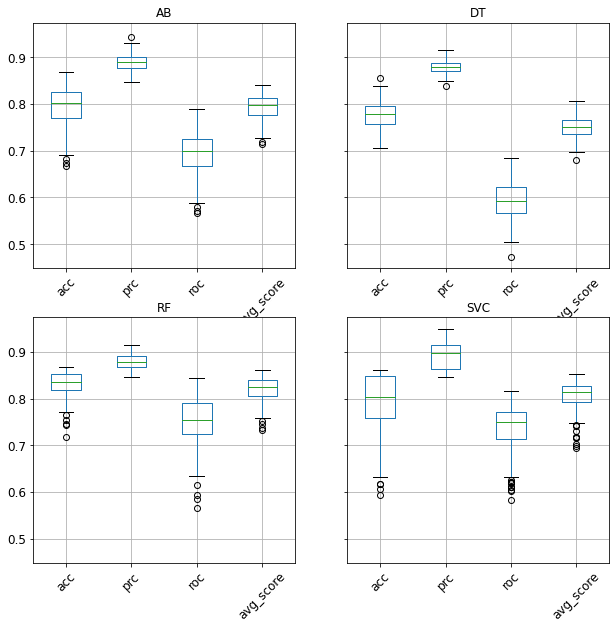

In [39]:
df_eval_group[['acc', 'prc', 'roc','avg_score']].boxplot(rot=45, fontsize=12, figsize=(10, 10))  
plt.show()

As we can observe in the summary table and the box plots, the *Random Forest Classifier* (RF) offers the best performance of the four evaluated classifiers, followed by the *Support Vector Machine Classifier* (SVC), *AdaBoost Classifier* (AB), and last the *Decision Tree Classifier* (DT). **SVC** and **AB** outperfom **RF** in *precision* but lag behind in *accuracy*. **DT** is the classifier with the lowest *area under the curve* (au_roc) performance, failing to properly distiguish between the classes (*pass*/*fail*).

To further evaluate the quality of the classifiers' prediction, let's look at the confusion matrices for each classifier's best setup:

In [40]:
print('Confusion Matrix of each classifier best setup:')
for clsfr in clsfrs:
    best_CL_setup = df_eval[df_eval['CLSFR']==clsfr]
    best_CL_setup = best_CL_setup[best_CL_setup['avg_score']==best_CL_setup['avg_score'].max()]
    ps = list(best_CL_setup['steps'])[0]
    acc, prc, roc, avg_scr, cm, mdl = model_evaluation(X_train, y_train, X_test, y_test, ps)
    print(clsfr, 'Classifier:')
    print(best_CL_setup[best_CL_setup.columns[:-5]])
    print('confusion matrix (fail/pass):')
    print(cm)
    print()

Confusion Matrix of each classifier best setup:
DT Classifier:
    CLSFR  CV  NF STDR  OSR   ST  FS
111    DT  SS   5   SS  ROS  PCA  10
confusion matrix (fail/pass):
[[  4  14]
 [ 29 142]]

RF Classifier:
    CLSFR  CV  NF STDR   OSR    ST  FS
180    RF  CV   5   NM  None  chi2  15
confusion matrix (fail/pass):
[[  4  14]
 [  4 167]]

AB Classifier:
    CLSFR  CV  NF STDR   OSR  ST FS
310    AB  CV   5   SS  None  MI  5
confusion matrix (fail/pass):
[[  2  16]
 [  7 164]]

SVC Classifier:
    CLSFR   CV  NF STDR  OSR  ST FS
521   SVC  SKF   5   SS  ROS  MI  5
confusion matrix (fail/pass):
[[  7  11]
 [ 28 143]]



For the four classifiers, the majority of the values are in the confusion matrix diagonal, revealing a good fit. However, the *Random Forest Classifier* presents most values in the diagonal, in line with previous observations. However, those models with oversampling present a more balance distribution between false positive and false negative.

### 5.2 Class Imbalance

Let's look at counter measures we tested to mitigate the problem of class imbalace, to evaluate if they were effective or not:

In [41]:
df_eval_group = df_eval.groupby(['CLSFR','OSR'])
df_eval_group[['acc', 'prc', 'roc', 'avg_score']].mean()

acc       prc       roc  avg_score
CLSFR OSR                                          
AB    None  0.834857  0.879191  0.703439   0.805829
      ROS   0.776898  0.897144  0.695738   0.789927
      SM    0.778467  0.890813  0.684083   0.784454
DT    None  0.787816  0.878430  0.592519   0.752922
      ROS   0.785775  0.876360  0.585658   0.749264
      SM    0.757816  0.883505  0.602613   0.747978
RF    None  0.846488  0.869541  0.758781   0.824937
      ROS   0.831141  0.877037  0.748824   0.819001
      SM    0.814786  0.890406  0.744049   0.816414
SVC   None  0.851738  0.857327  0.728594   0.812553
      ROS   0.752941  0.914651  0.746722   0.804771
      SM    0.761390  0.905424  0.734334   0.800383

From above table we cannot observe a significant contribution to the *auc_roc* performance for the classifiers, being *auc_roc* the metric that represents the likelihood of the model distinguishing instances from two classes (pass/fail). 

### 5.3 Feature Selection

Let's look at the feature selection techniques employed during the model selection process, to evaluate their contribution to the overall performance:

In [42]:
df_eval_group = df_eval.groupby(['ST', 'FS'])
df_eval_group[['acc', 'prc', 'roc', 'avg_score']].mean()

acc       prc       roc  avg_score
ST   FS                                           
MI   5     0.782936  0.883222  0.661531   0.775896
     10    0.796926  0.882770  0.684141   0.787945
     15    0.809299  0.886996  0.708643   0.801646
None None  0.809432  0.883428  0.711029   0.801297
PCA  5     0.779255  0.883676  0.676560   0.779830
     10    0.796098  0.881687  0.684558   0.787448
     15    0.803782  0.879428  0.688762   0.790657
chi2 5     0.795076  0.893165  0.706727   0.798323
     10    0.809583  0.895208  0.726331   0.810374
     15    0.811717  0.893967  0.730745   0.812143

From above table we can observe that *chi2* feature selection technique contributes most to the model selection process, with a number of features set at 15. 

### 5.4 Descriptive Knowledge

Next let's focus on the knowledge gained from the modelling process, and compared it with the insight gathered during the *Exploratory Data Analysis*. From the *Random Forest Classifier* with the best performance setup, let's plot its features based on mean decrease in impurity (MDI), computed as the mean and standard deviation of accumulation of the impurity decrease within each tree:

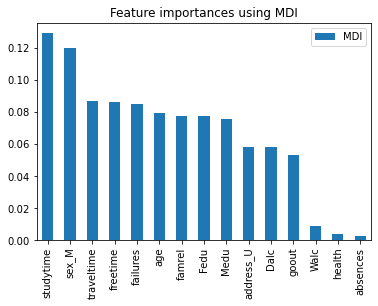

In [43]:
df_fi.transpose().sort_values(by=['MDI'],ascending=False).plot.bar()
plt.title("Feature importances using MDI")
plt.show()

From the plot, we can observe the most importance features. Taking aside the features related to gender and age of the students, some relevant factors to the student success are study time, travel time, free time, past failures, family relationships and parents' education. 

There are other less relevant factors, such as going out with friends, alcohol consumption, and type of household (urban/rural).

## 6 - Conclusion

Discussion and conclusion section goes above expectations. E.g. includes three of the following: discussion of learning and takeaways or discussion of why something didn’t work or suggests ways to improve.

Identifying the social and demographic contributing factors in students' performance is key to the human development. In particular, analytical studies focus on improving the management of school resources to ensure a high rate of success in students educational journey.

In this project, we explore the capability of predicting if a student will pass or fail a core Portuguese course by using demographic, social and other school related data. 

For achieving this goals, we implemented a model selection process using cross-validation to evaluate different techniques on:
1. Standardization (StandardScaler, Normalizer)
2. Oversampling (RandomOverSampler, SMOTE)
3. Feature Selection (PCA, chi2, Mutual Information)
4. Cross Validation (Kfold, StratifiedKFold, ShuffleSplit)
5. Classification (Decision Trees (DT), Random Forests (RF), AdaBoost (AB), Support Vector Machines (SVM))

That resulted in a total of 612 different model setups, which were evaluated using the mean of three scoring metrics: accuracy, precision, and au_roc, over the number of folds for the validation set.

The obtained results reveal that it is possible to achieve an average predictive score of the three scoring metrics of 86%, being Random Forest algorithm the best classifier. 

Additionally, we observed that the problem of data imbalance and its mitigation by using oversampling techniques didn't have the expected result in improving the model capability in distiguishing the two classes. Further analysis focusing on the minority class may be required to understand the issue by using other sampling techniques.

Moreover, by looking at the importance of the feature in the best predictive model, we found that the most important factors in the student course success are: study time, travel time, free time, past failures, family relationships and parents' education; in line with what was observed during the data exploration analysis.

This project was based on mostly on searching for the best classifiers for the binary target variable using cross-validation, however, little was done on trying to optimize each classifier's hyperparameters, this is an area for improvement for this study in the future. Additionally, we could explore the capability of predicting the final grades using regression algorithms. 